In [59]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.svm import LinearSVC
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, KFold, cross_val_score
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, LabelEncoder, OrdinalEncoder, LabelBinarizer, label_binarize
from sklearn.metrics import *
from prettytable import PrettyTable
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore")

## Preprocessing

In [2]:
features = pd.read_csv('train_values.csv')
labels = pd.read_csv('train_labels.csv')

In [3]:
data = features.merge(labels, how = 'inner', on = 'building_id')
print(data.shape)
data.head(1)

(260601, 40)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [5]:
# check missing values and duplicates
print('No of NaN/Null values: {}'.format(data.isnull().values.sum()))
print('No of duplicates: {}'.format(sum(data.duplicated())))

No of NaN/Null values: 0
No of duplicates: 0


In [6]:
# Drop the identifier column
data = data.drop('building_id', axis = 1)

### Imbalance data —— stratify split

In [7]:
y_labels = data.damage_grade

<Axes: title={'center': 'Number of Buildings with Each Damage Grade'}, xlabel='damage_grade', ylabel='count'>

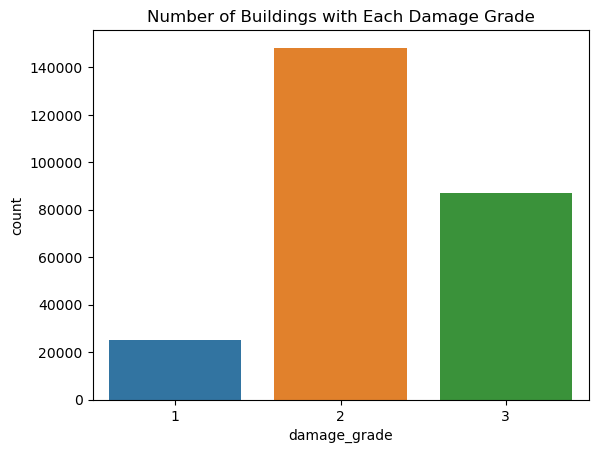

In [8]:
plt.title("Number of Buildings with Each Damage Grade")
sns.countplot(x=y_labels)

The dataset is imbalanced. Class 2 is dominant over other classes.

In [9]:
grade_count = y_labels.value_counts().sort_index()

In [10]:
print('Overall dataset, distribution of labels: (%)')
print(grade_count/len(data)*100)

Overall dataset, distribution of labels: (%)
1     9.640792
2    56.891186
3    33.468022
Name: damage_grade, dtype: float64


In [11]:
# stratify split
seed = 42
train_data, test_data = train_test_split(data, 
                     stratify=y_labels, random_state=seed, test_size=0.2)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

X_train = train_data.iloc[:, :-1]
X_test = test_data.iloc[:, :-1]
y_train = train_data.damage_grade
y_test = test_data.damage_grade

In [12]:
train_grade_count = y_train.value_counts().sort_index()
print('Startify split train labels, distribution: (%)')
print(train_grade_count/len(train_data)*100)

Startify split train labels, distribution: (%)
1     9.640733
2    56.891309
3    33.467959
Name: damage_grade, dtype: float64


In [13]:
train_data.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,...,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000,208480.000000
mean,13.894441,701.395127,6259.218222,2.129432,26.539092,8.016333,5.432310,0.088589,0.762462,0.034257,...,0.033548,0.008078,0.000950,0.000379,0.001084,0.000168,0.000144,0.000091,0.005128,2.238272
std,8.030768,412.506797,3644.644892,0.726968,73.509383,4.399541,1.909589,0.284150,0.425576,0.181890,...,0.180062,0.089511,0.030803,0.019463,0.032907,0.012956,0.011995,0.009546,0.071424,0.611813
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,12.000000,706.000000,6276.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,21.000000,1050.000000,9411.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,30.000000,1427.000000,12565.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


### Feature selection

In [14]:
cor = train_data.corr()

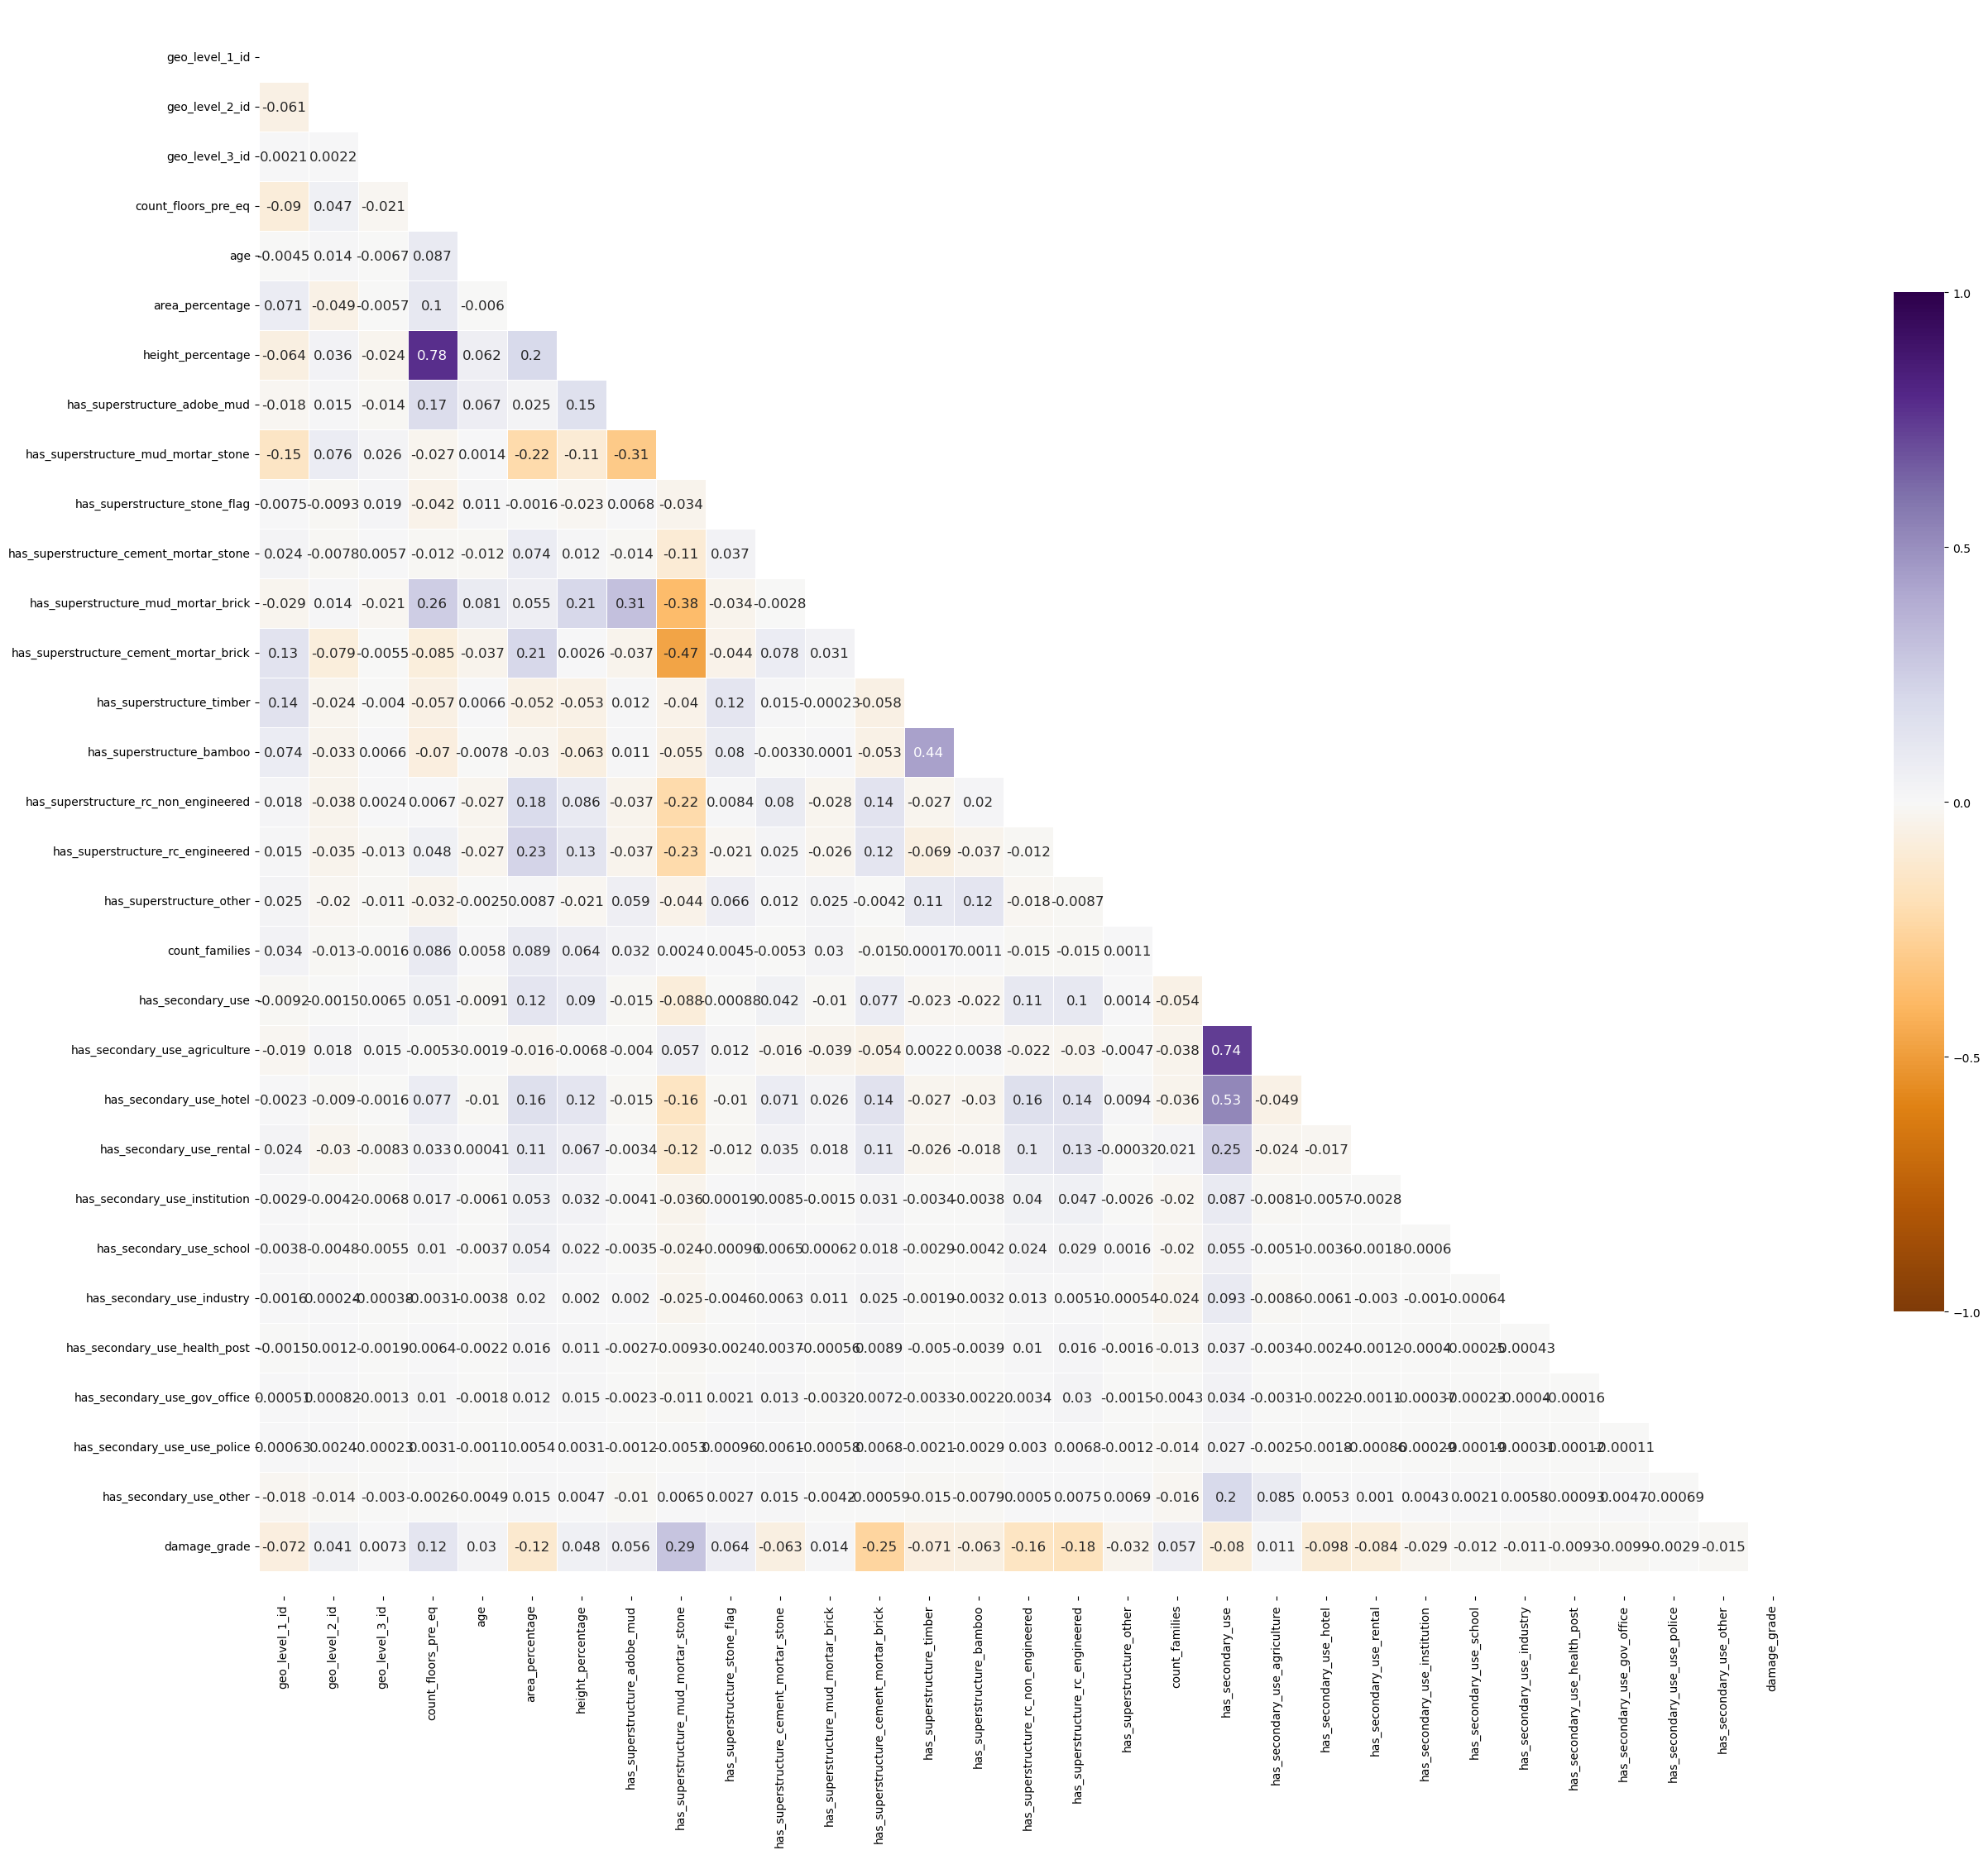

In [15]:
mask = np.zeros_like(cor, dtype=bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(30, 40))
heatmap = sns.heatmap(cor,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'PuOr',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(cor.columns, rotation = 0)
ax.set_xticklabels(cor.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.savefig("heatmap.png", bbox_inches='tight', dpi=600)
plt.show()

there is great correlation among the height_percentage and count_floors_pre_eq columns which makes sense.
as well, high correlation among has_secondary_use and has_secondary_use_agriculture columns, take a look later on.

<Axes: >

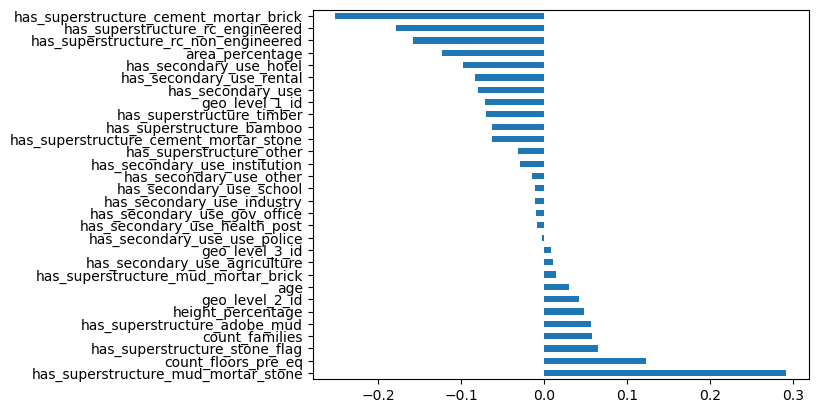

In [16]:
(cor.damage_grade.drop('damage_grade').sort_values(ascending=False).plot.barh())

In [17]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.7)
print('correlated features: ', len(set(corr_features)) )
print(corr_features)

correlated features:  2
{'has_secondary_use_agriculture', 'height_percentage'}


In [19]:
cols_to_drop=['has_secondary_use_agriculture', 'height_percentage']
X_train=X_train.drop(cols_to_drop,axis=1)
X_test=X_test.drop(cols_to_drop,axis=1)
X_train.shape

(208480, 36)

In [20]:
# Make copy to avoid changing original data 
X_train1 = X_train.copy()
X_test1 = X_test.copy()

### Category Columns

In [21]:
# Fileterning out the cat cols from the numeric cols
cat_cols = [col for col in X_train1.columns if X_train1[col].dtype == 'O']
X_train1[cat_cols].head(2)

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
0,t,r,n,f,q,s,d,v
1,t,r,n,f,q,t,d,v


In [22]:
X_train1[cat_cols].nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
legal_ownership_status     4
dtype: int64

### Numeric Columns

In [23]:
# defning the numeric cols
num_cols = list(set(X_train1.columns) - set(cat_cols)) 
X_train1[cat_cols].head(2)

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
0,t,r,n,f,q,s,d,v
1,t,r,n,f,q,t,d,v


In [24]:
int_variables = [col for col in num_cols if X_train1[col].nunique() != 2]
X_train1[int_variables].nunique()

geo_level_3_id         11380
count_families            10
area_percentage           84
geo_level_2_id          1409
age                       41
count_floors_pre_eq        9
geo_level_1_id            31
dtype: int64

In [25]:
bin_variables = [col for col in num_cols if col not in int_variables]

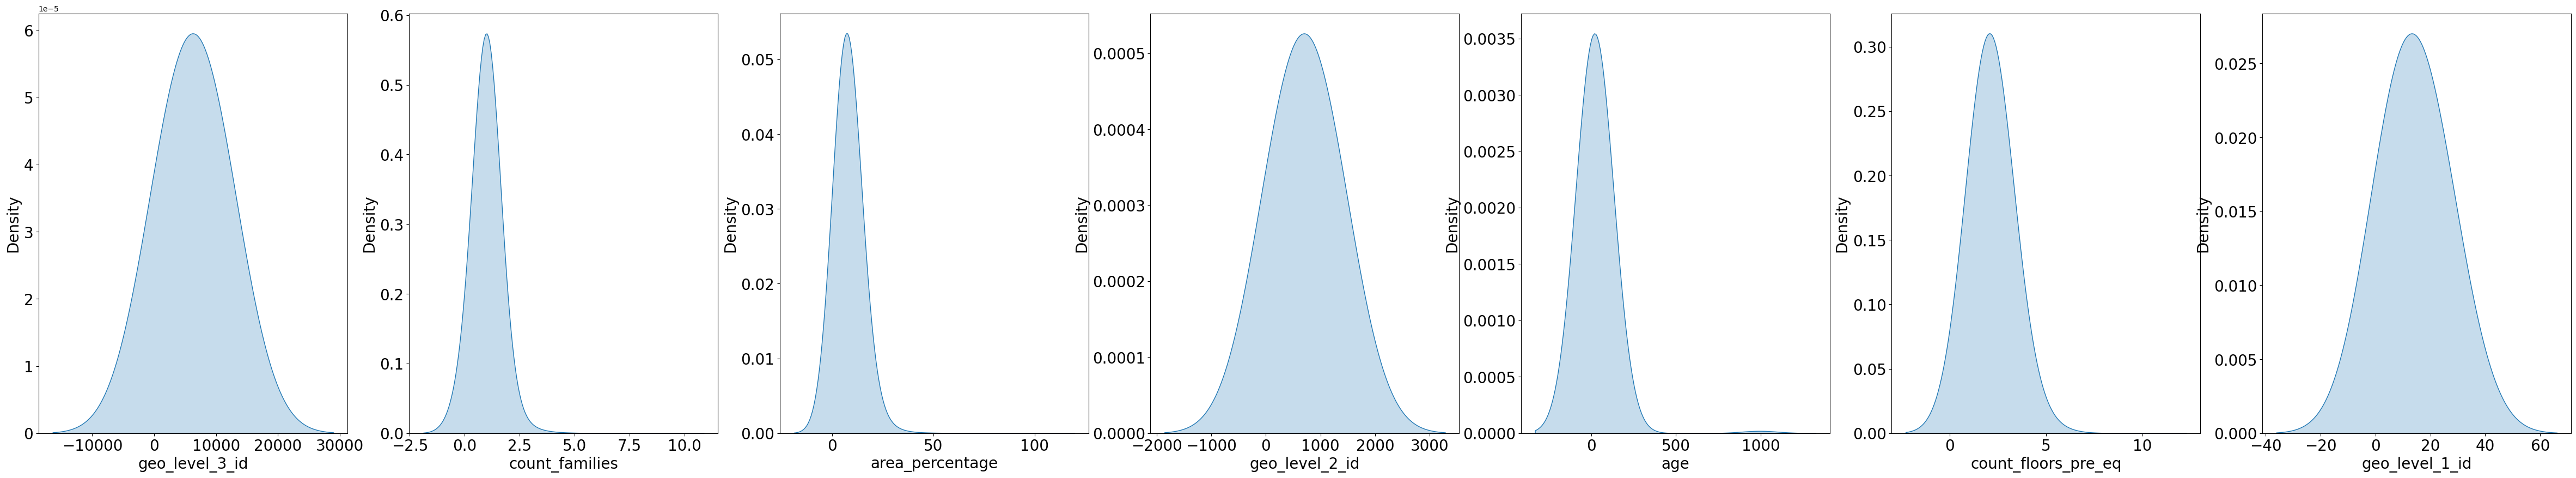

In [26]:
# Check the distribution of numerical variables in preparation for removing outliers & standardization
int_var_df = X_train1.loc[:, int_variables]
fig, axs = plt.subplots(1, 7, figsize=(60, 10))
for number, ax in enumerate(axs.flat):
    sns.kdeplot(int_var_df.iloc[:, number], bw=1.5, ax=ax,
                shade=True, cbar="GnBu_d")
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)

In [110]:
fig.savefig('distrubution1.png', bbox_inches="tight")

We first tried to use log transformation, but it's difficult to process geo id, so we decided to standardize directly.

In [95]:
# Applying the logs and create new sensible column names on train and test data
# logged_train = X_train.loc[:, int_variables].apply(lambda x: np.log(x+1))
# logged_test = X_test.loc[:, int_variables].apply(lambda x: np.log(x+1))
# log_names = ["log_{}".format(x) for x in int_variables]
    
# std = StandardScaler()
# stand_logs = std.fit_transform(logged_train)
# stand_logs_df = pd.DataFrame(stand_logs, columns=log_names) 
# logged_test_df = pd.DataFrame(std.transform(logged_test), columns=log_names)

# for log_col, log_col1, int_col in zip(stand_logs_df,logged_test_df, int_variables):
#     X_train.loc[:, log_col] = stand_logs_df.loc[:, log_col]
#     X_test.loc[:, log_col1] = logged_test_df.loc[:, log_col1]
#     X_train.drop(columns=int_col, inplace=True)
#     X_test.drop(columns=int_col, inplace=True)

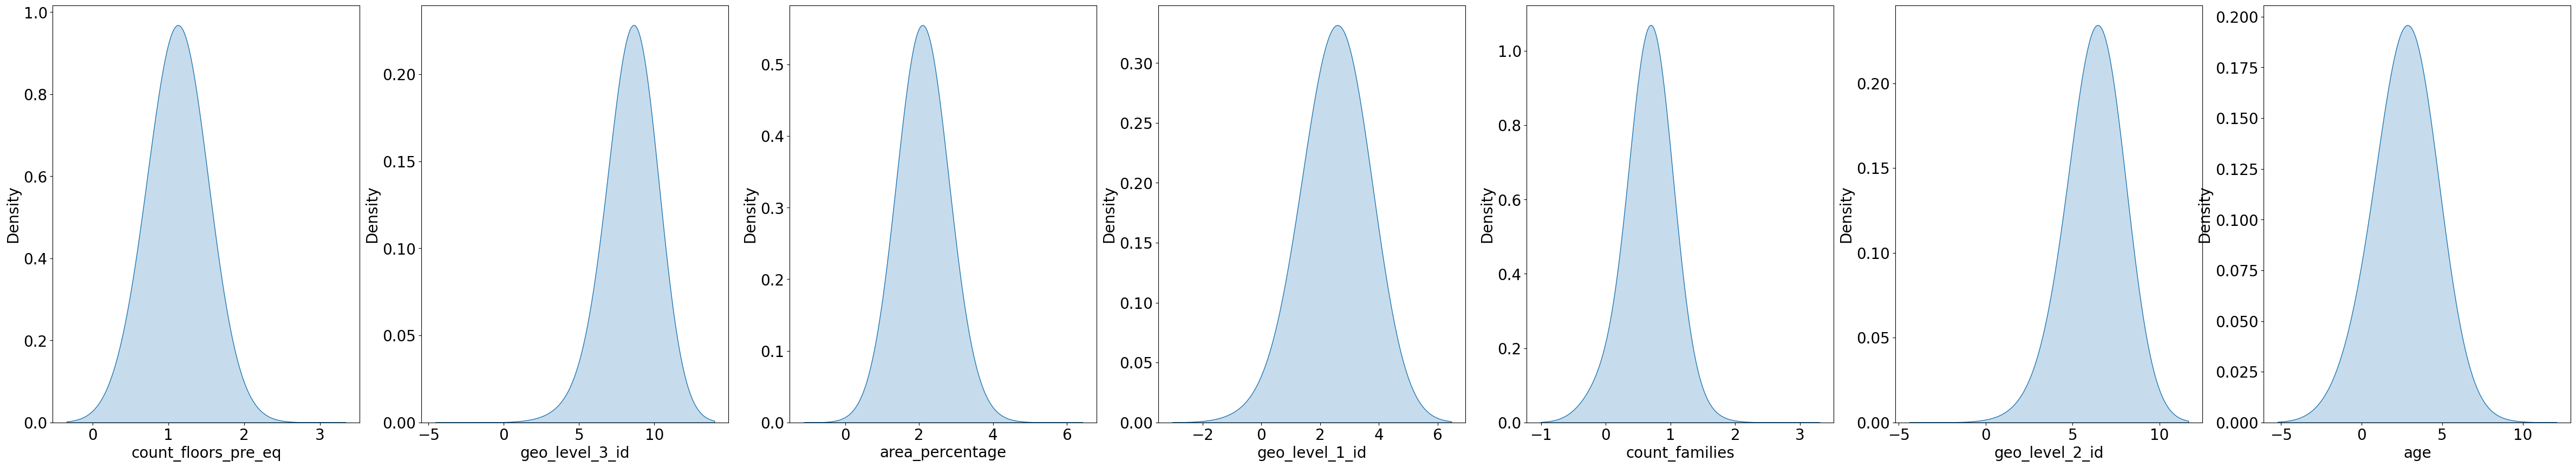

In [96]:
# Plot the newly created plot log variables
# fig, axs = plt.subplots(1, 7, figsize=(60, 10))
# for number, ax in enumerate(axs.flat):
#     sns.kdeplot(logged_train.iloc[:, number], bw=1.5, ax=ax,
#                 shade=True, cbar="GnBu_d")
#     ax.tick_params(axis="both", which="major", labelsize=20)
#     ax.set_xlabel(ax.get_xlabel(), fontsize=20)
#     ax.set_ylabel(ax.get_ylabel(), fontsize=20)
#     ax.legend(fontsize=30, loc="upper right")
# fig.savefig('distrubution2.png', bbox_inches="tight")

## Random Forest

### Preparation

In [30]:
enc = OrdinalEncoder()
X_train1[cat_cols] = enc.fit_transform(X_train1[cat_cols])
X_test1[cat_cols] = enc.transform(X_test1[cat_cols])

In [27]:
#function to plot confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
def perform_model(y_test, y_pred, class_labels, cm_normalize=True, print_cm=True):
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('\n {}'.format(cm))

    plt.figure(figsize=(4,4))
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print(classification_report(y_test, y_pred))

In [29]:
class_labels=['Low','Medium','High']

In [52]:
def test_params(model, X_train, y_train, X_test, y_test, **params):
    # Setting the params of the model using set_param method
    model.set_params(**params)
    
    # Fitting the model with the params
    model.fit(X_train, y_train)

    # Getting the training and validation accuracy scores
    train_f1 = f1_score(y_train, model.predict(X_train), average='micro')
    test_f1 = f1_score(y_test, model.predict(X_test), average='micro')
    return train_f1, test_f1

In [53]:
def test_param_and_plot(model, X_train, y_train, X_test, y_test, older_param, param_name, param_values):
    # creating training and validation accuracy lists
    train_accuracy, test_accuracy = [], []

    # creating the accuracy list
    accuracies_list = []
    
    # setting the values of the paramters which have been found to work the best
    for key, value in older_param.items():
            setattr(model, key, value)
            
    # running the for loop over list of param values
    for value in param_values:
        params = {param_name: value}
        
        # creating the dictionary to be returned in the end
        accuracies = {}
        # running the test param function and getting back the train and validation accuracy scores 
        train_f, test_f = test_params(model, X_train, y_train, X_test, y_test, **params)
        train_accuracy.append(train_f)
        test_accuracy.append(test_f)

        # adding items to the dictionary
        accuracies['param'] =  param_name
        accuracies['param_value'] = value
        accuracies['train_score'] = train_f
        accuracies['test_score'] = test_f
        accuracies_list.append(accuracies)
        
    # plotting a line chart of train and validation accuracy scores 
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_accuracy, 'b-o')
    plt.plot(param_values, test_accuracy, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Test'])

    return accuracies_list

### Baseline and SMOTE

In [31]:
# Baseline
rfc = RandomForestClassifier(max_features = "sqrt", n_estimators = 100, random_state = seed, oob_score = True) #class_weight='balanced'
rfc.fit(X_train1, y_train)
# Making predictions on train and test sets
preds_train = rfc.predict(X_train1)
preds_test = rfc.predict(X_test1)

In [32]:
# Getting the f1 micro avr scores for train and test set
f1_train = f1_score(y_train, preds_train, average='micro')
f1_test = f1_score(y_test, preds_test, average='micro')

print(f"Train average f1: {f1_train}")
print(f"Test average f1: {f1_test}")

Train average f1: 0.983571565617805
Test average f1: 0.7190767636845034


In [33]:
# SMOTE
pip_smote = imb_make_pipeline(SMOTE(),rfc)
pip_smote.fit(X_train1, y_train)
preds_train_smote = pip_smote.predict(X_train1)
preds_test_smote = pip_smote.predict(X_test1)

In [34]:
f1_train_smote = f1_score(y_train, preds_train_smote, average='micro')
f1_test_smote = f1_score(y_test, preds_test_smote, average='micro')

print("SMOTE:")
print(f"Train average f1: {f1_train_smote}")
print(f"Test average f1: {f1_test_smote}")

SMOTE:
Train average f1: 0.9826410207214121
Test average f1: 0.7082174171639071


--------------------
| Confusion Matrix |

 [[ 2467  2457   101]
 [ 1250 24305  4097]
 [  132  6605 10707]]


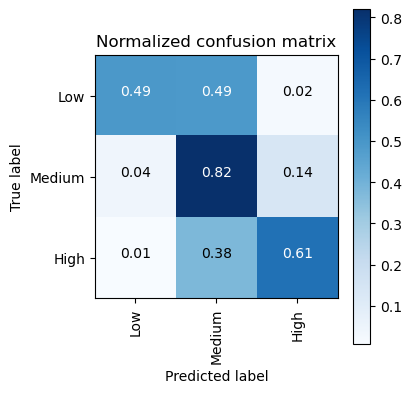

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

           1       0.64      0.49      0.56      5025
           2       0.73      0.82      0.77     29652
           3       0.72      0.61      0.66     17444

    accuracy                           0.72     52121
   macro avg       0.70      0.64      0.66     52121
weighted avg       0.72      0.72      0.71     52121



In [35]:
perform_model(y_test, preds_test, class_labels=class_labels)

--------------------
| Confusion Matrix |

 [[ 2784  2120   121]
 [ 1773 23202  4677]
 [  198  6319 10927]]


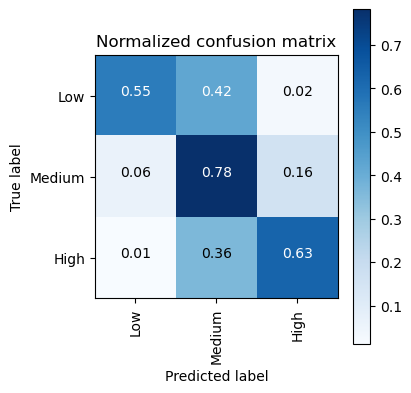

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

           1       0.59      0.55      0.57      5025
           2       0.73      0.78      0.76     29652
           3       0.69      0.63      0.66     17444

    accuracy                           0.71     52121
   macro avg       0.67      0.65      0.66     52121
weighted avg       0.71      0.71      0.71     52121



In [36]:
perform_model(y_test, preds_test_smote, class_labels=class_labels)

Decide to use SMOTE to solve imbalances. 
Noted obvious overfit problem.

### Tuning parameter

#### Learning Curve

In [47]:
pip_smote.get_params()

{'memory': None,
 'steps': [('smote', SMOTE()),
  ('randomforestclassifier',
   RandomForestClassifier(oob_score=True, random_state=42))],
 'verbose': False,
 'smote': SMOTE(),
 'randomforestclassifier': RandomForestClassifier(oob_score=True, random_state=42),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100

In [50]:
good_params = {'randomforestclassifier__random_state': 42} 

[{'param': 'randomforestclassifier__n_estimators',
  'param_value': 50,
  'train_score': 0.9824395625479663,
  'test_score': 0.705723220966597},
 {'param': 'randomforestclassifier__n_estimators',
  'param_value': 100,
  'train_score': 0.9826314274750576,
  'test_score': 0.7079104391703919},
 {'param': 'randomforestclassifier__n_estimators',
  'param_value': 150,
  'train_score': 0.9825786646201075,
  'test_score': 0.7090040482722895},
 {'param': 'randomforestclassifier__n_estimators',
  'param_value': 200,
  'train_score': 0.9826122409823485,
  'test_score': 0.7095220736363461}]

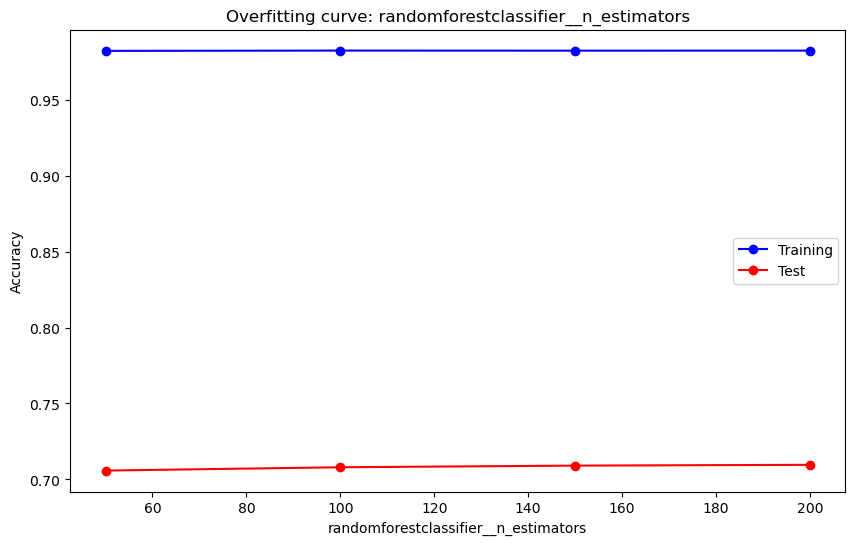

In [51]:
test_param_and_plot(pip_smote, X_train1, y_train, X_test1, y_test, good_params, 'randomforestclassifier__n_estimators', [50,100,150,200])

In [48]:
scorel = []
for i in range(0, 200, 50):
    rfc_ = RandomForestClassifier(n_estimators=i + 1,
                                 n_jobs=-1,
                                 random_state=seed)
    pip_smote_ = imb_make_pipeline(SMOTE(),rfc_)
    
    score = cross_val_score(pip_smote_, X_train1, y_train, scoring='f1_micro', cv=5).mean()
    scorel.append(score)

0.7053146584804297 151


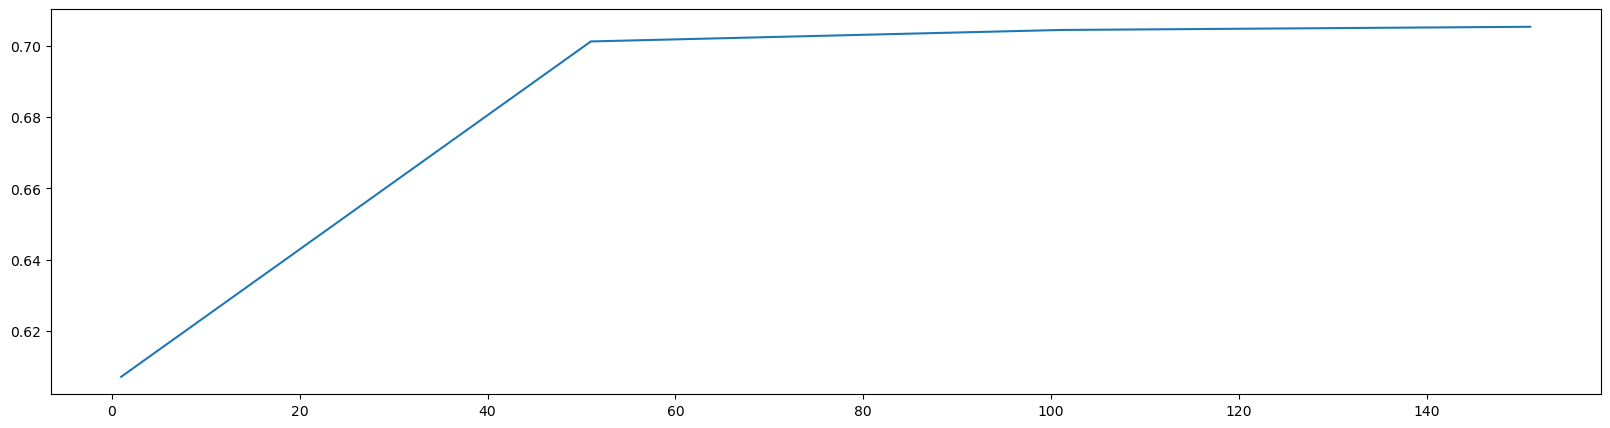

In [54]:
print(max(scorel), (scorel.index(max(scorel)) * 50) + 1)
plt.figure(figsize=[20, 5])
plt.plot(range(1, 201, 50), scorel)
plt.show()

n_estimators is not causing a great accuracy change, we just keep it to 150.

In [55]:
good_params['randomforestclassifier__n_estomators'] = 150 

[{'param': 'randomforestclassifier__max_depth',
  'param_value': 5,
  'train_score': 0.5210715656178051,
  'test_score': 0.5234550373170124},
 {'param': 'randomforestclassifier__max_depth',
  'param_value': 10,
  'train_score': 0.6320654259401381,
  'test_score': 0.6318374551524337},
 {'param': 'randomforestclassifier__max_depth',
  'param_value': 15,
  'train_score': 0.7128933231005372,
  'test_score': 0.6775388039369927},
 {'param': 'randomforestclassifier__max_depth',
  'param_value': 20,
  'train_score': 0.801693207981581,
  'test_score': 0.7015406458049539}]

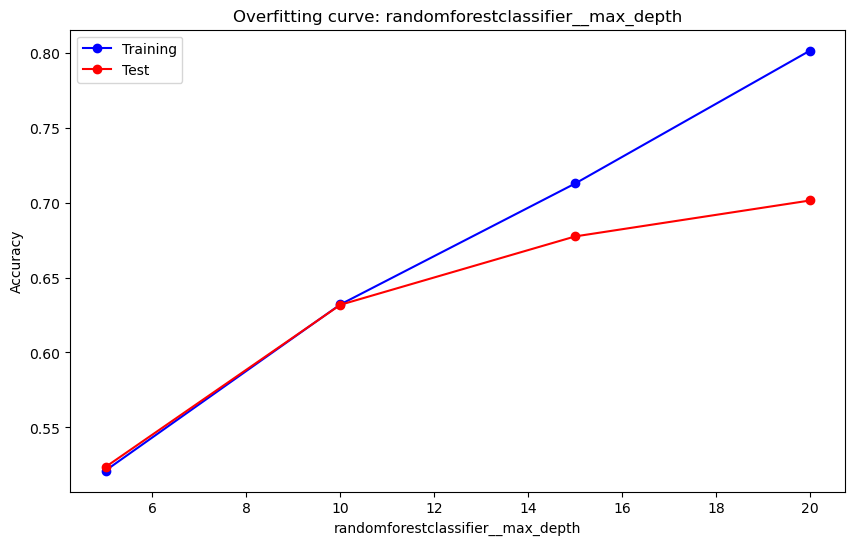

In [56]:
test_param_and_plot(pip_smote, X_train1, y_train, X_test1, y_test, good_params, 'randomforestclassifier__max_depth', [5,10,15,20])

[{'param': 'randomforestclassifier__max_depth',
  'param_value': 20,
  'train_score': 0.7995443207981581,
  'test_score': 0.7004470367030563},
 {'param': 'randomforestclassifier__max_depth',
  'param_value': 30,
  'train_score': 0.9373321181887951,
  'test_score': 0.7140883712898832},
 {'param': 'randomforestclassifier__max_depth',
  'param_value': 40,
  'train_score': 0.9799597083653108,
  'test_score': 0.7100209128758082}]

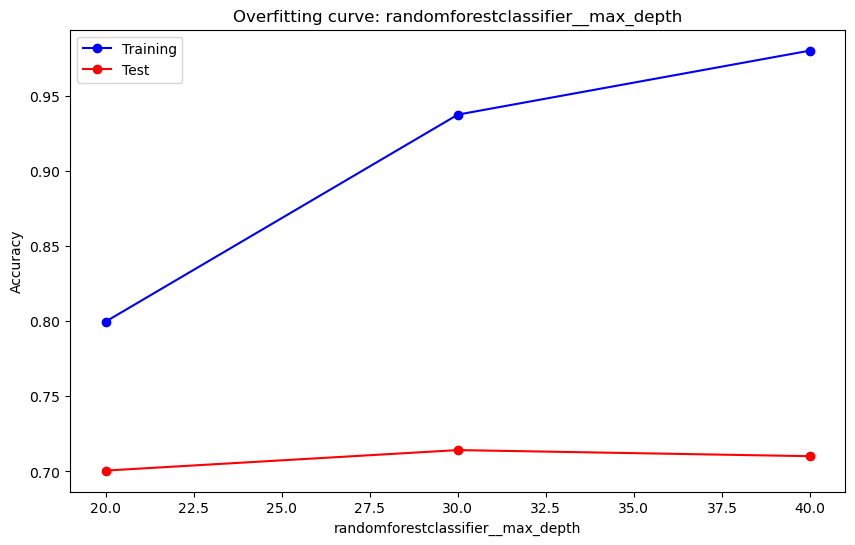

In [57]:
test_param_and_plot(pip_smote, X_train1, y_train, X_test1, y_test, good_params, 'randomforestclassifier__max_depth', [20,30,40])

In [130]:
good_params['randomforestclassifier__max_depth'] = 40 

The test score was first increasing and then started to decrease, so we will choose the max_depth at the place where it gives the highest accuracy.

[{'param': 'randomforestclassifier__min_samples_split',
  'param_value': 2,
  'train_score': 0.9802427091327706,
  'test_score': 0.7108651023579746},
 {'param': 'randomforestclassifier__min_samples_split',
  'param_value': 3,
  'train_score': 0.9724577897160399,
  'test_score': 0.7131290650601485},
 {'param': 'randomforestclassifier__min_samples_split',
  'param_value': 5,
  'train_score': 0.9435437452033768,
  'test_score': 0.7180215268317951},
 {'param': 'randomforestclassifier__min_samples_split',
  'param_value': 7,
  'train_score': 0.9186013046815042,
  'test_score': 0.7183668770744998},
 {'param': 'randomforestclassifier__min_samples_split',
  'param_value': 10,
  'train_score': 0.8898119723714505,
  'test_score': 0.7189808330615299}]

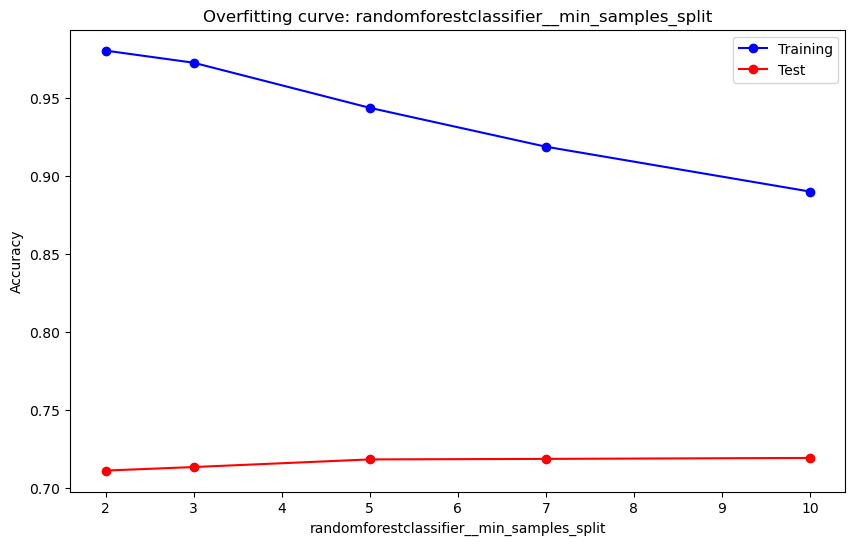

In [61]:
test_param_and_plot(pip_smote, X_train1, y_train, X_test1, y_test, good_params, 'randomforestclassifier__min_samples_split', [2, 3, 5, 7, 10])

The test accuracy curve seems to be flattening after 7.

#### Bayes Optimization

In [76]:
def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    rfc = RandomForestClassifier(n_estimators=int(n_estimators),
                                 min_samples_split=int(min_samples_split),
                                 max_features=min(max_features, 0.999), # float
                                 max_depth=int(max_depth),
                                 n_jobs=-1,
                                 random_state=seed,
                                 class_weight='balanced')
    pip_smote = imb_make_pipeline(SMOTE(),rfc)
    val = cross_val_score(pip_smote, X_train1, y_train, scoring='f1_micro', cv=5).mean()
    return val

In [77]:
# Value space defined based on the learning curve
pbounds = {'n_estimators': (50, 150),  
               'min_samples_split': (3, 7),
               'max_features': (0.1, 0.999),
               'max_depth': (18, 40)}

In [78]:
rf_bo = BayesianOptimization(
        f=rf_cv, 
        pbounds=pbounds,
        verbose=2, # print all
        random_state=seed,
    )

In [79]:
rf_bo.maximize()

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7161    | 26.24     | 0.9547    | 5.928     | 109.9     |
| 2         | 0.7061    | 21.43     | 0.2402    | 3.232     | 136.6     |
| 3         | 0.7162    | 31.22     | 0.7366    | 3.082     | 147.0     |
| 4         | 0.7121    | 36.31     | 0.2909    | 3.727     | 68.34     |
| 5         | 0.7194    | 24.69     | 0.5718    | 4.728     | 79.12     |
| 6         | 0.7185    | 24.43     | 0.4558    | 5.208     | 79.27     |
| 7         | 0.7105    | 28.78     | 0.999     | 3.0       | 79.04     |
| 8         | 0.7168    | 23.07     | 0.8552    | 3.165     | 78.18     |
| 9         | 0.7157    | 23.75     | 0.4158    | 3.657     | 81.37     |
| 10        | 0.7158    | 25.3      | 0.3248    | 4.21      | 76.64     |
| 11        | 0.7164    | 35.55     | 0.4115    | 3.732     | 147.3     |
| 12        | 0.7216    | 33.05     | 

KeyboardInterrupt: 

Due to excessive time consumption, we manually paused Bayesian optimization after the 12th iteration.
However, the current results roughly align with the learning curve results.

In [80]:
#Tuning model
rfc_tun = RandomForestClassifier(n_estimators=150,
                                 min_samples_split=6,
                                 max_features=0.6, # float
                                 max_depth=33,
                                 random_state=seed,
                                 criterion='gini',
                                 bootstrap=True,
                                 min_samples_leaf=1)
rfc_tun.fit(X_train1, y_train)
y_pred1 = rfc_tun.predict(X_test1)
f1_score(y_test, y_pred1, average='micro')

0.7388960303908214

In [81]:
pip_smote_tun = imb_make_pipeline(SMOTE(),rfc_tun)
pip_smote_tun.fit(X_train1, y_train)
preds_train_tun = pip_smote_tun.predict(X_train1)
preds_test_tun = pip_smote_tun.predict(X_test1)

In [83]:
f1_score(y_test, preds_test_tun, average='micro')

0.72678958577157

--------------------
| Confusion Matrix |

 [[ 2572  2376    77]
 [ 1182 24758  3712]
 [  111  6151 11182]]


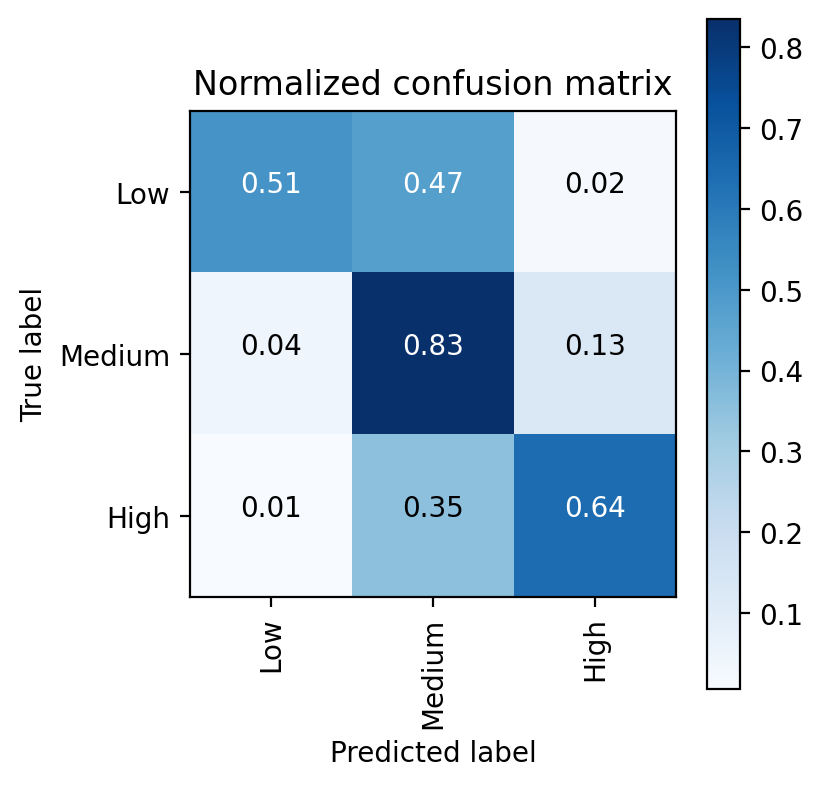

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

           1       0.67      0.51      0.58      5025
           2       0.74      0.83      0.79     29652
           3       0.75      0.64      0.69     17444

    accuracy                           0.74     52121
   macro avg       0.72      0.66      0.69     52121
weighted avg       0.74      0.74      0.73     52121



In [128]:
perform_model(y_test, y_pred1, class_labels=class_labels)

--------------------
| Confusion Matrix |

 [[ 2881  2061    83]
 [ 1745 23522  4385]
 [  188  5778 11478]]


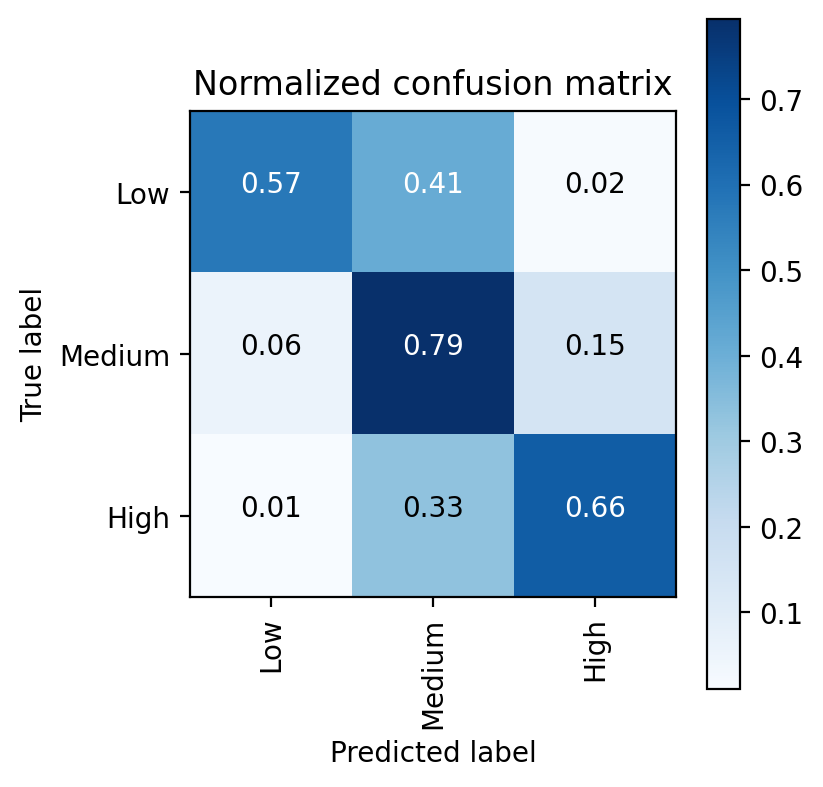

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

           1       0.60      0.57      0.59      5025
           2       0.75      0.79      0.77     29652
           3       0.72      0.66      0.69     17444

    accuracy                           0.73     52121
   macro avg       0.69      0.67      0.68     52121
weighted avg       0.73      0.73      0.73     52121



In [129]:
perform_model(y_test, preds_test_tun, class_labels=class_labels)

Text(0.5, 0, 'Gini importance')

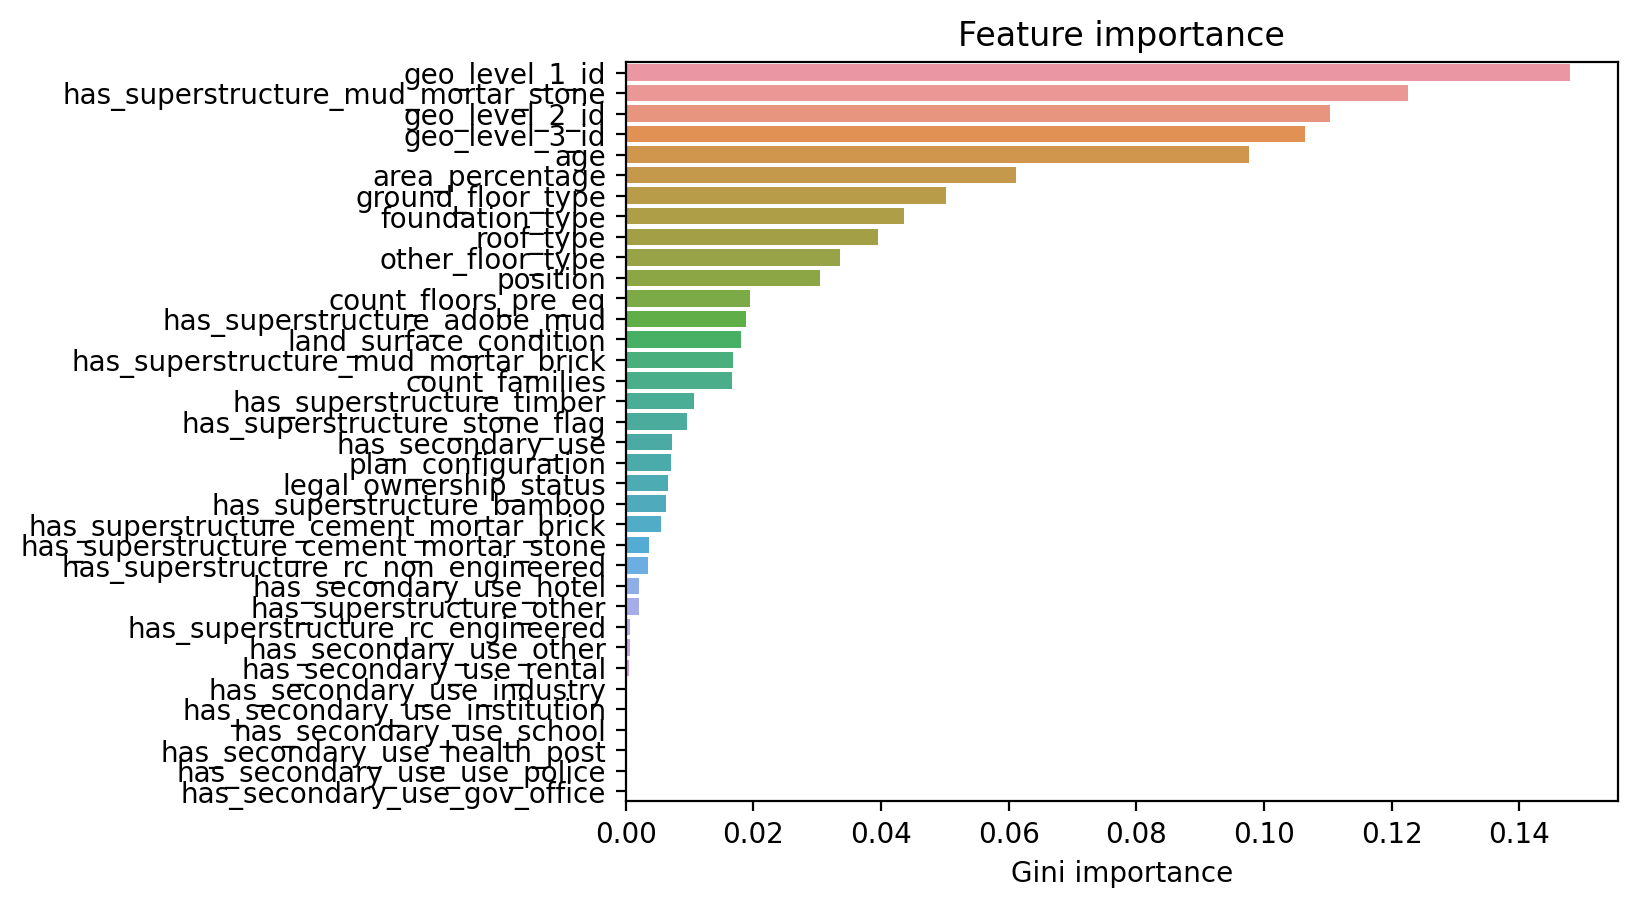

In [127]:
features = X_train1.columns
importances = rfc_tun.feature_importances_
idx = np.argsort(importances)[::-1]

sns.barplot(x = importances[idx], y = features[idx])
plt.title("Feature importance")
plt.xlabel("Gini importance")

Text(0.5, 0, 'Gini importance')

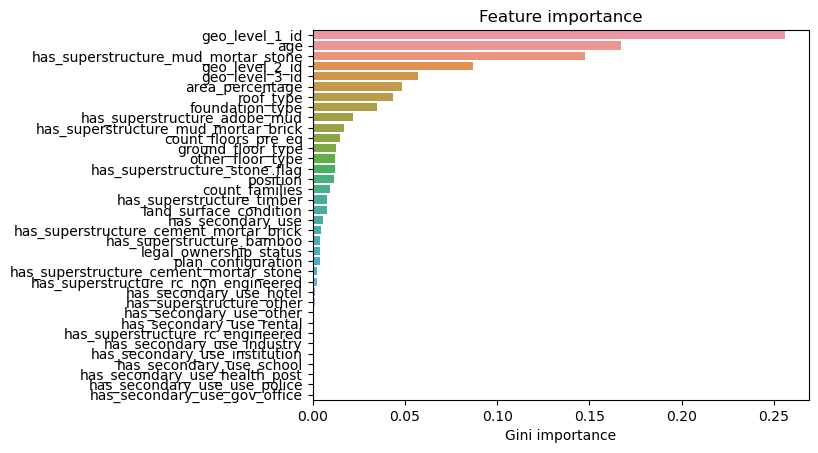

In [106]:
features = X_train1.columns
importances = rfc.feature_importances_
idx = np.argsort(importances)[::-1]

sns.barplot(x = importances[idx], y = features[idx])
plt.title("Feature importance")
plt.xlabel("Gini importance")

## Deep Learning

In [93]:
from keras.models import Sequential
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,Conv1D,GRU,Dropout
from keras.layers import BatchNormalization,MaxPooling1D,Flatten
import tensorflow as tf
from kerastuner.tuners import BayesianOptimization,Hyperband,RandomSearch

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

### Functions

In [89]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Baseline: 3 Dense

In [116]:
sc = StandardScaler()
X_train1[int_variables] = sc.fit_transform(X_train1[int_variables])
X_test1[int_variables] = sc.transform(X_test1[int_variables])

In [117]:
x_train = pd.DataFrame(X_train1, columns = X_train1.columns)
x_test = pd.DataFrame(X_test1, columns = X_train1.columns)

In [118]:
le = LabelEncoder().fit(y_train)
y_train_ohc = le.transform(y_train)
y_test_ohc = le.transform(y_test)

lb = LabelBinarizer().fit(y_train_ohc)
y_train_ohc = lb.transform(y_train_ohc)
y_test_ohc = lb.transform(y_test_ohc)

print("le labels:", le.classes_)
print("lb labels:", lb.classes_)

le labels: [1 2 3]
lb labels: [0 1 2]


In [119]:
model = Sequential()
# Add layers, first layer needs input dimension
model.add(Dense(64, input_shape = (x_train.shape[1],), activation="relu"))
model.add(Dense(36, activation="relu"))
model.add(Dense(3, activation = "softmax"))

# add loss function and optimizer
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy",f1_m])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2368      
                                                                 
 dense_5 (Dense)             (None, 36)                2340      
                                                                 
 dense_6 (Dense)             (None, 3)                 111       
                                                                 
Total params: 4819 (18.82 KB)
Trainable params: 4819 (18.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
es=EarlyStopping(monitor='val_f1_m', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [97]:
tf1 = model.fit(x = x_train, y = y_train_ohc, 
                    shuffle = True, 
                    #validation_split = 0.3,
                    batch_size = 64,                    
                    epochs = 30)

Epoch 1/30
3258/3258 [==============================] - 6s 2ms/step - loss: 0.6903 - accuracy: 0.6757 - f1_m: 0.6712
Epoch 2/30
3258/3258 [==============================] - 5s 1ms/step - loss: 0.6885 - accuracy: 0.6776 - f1_m: 0.6735
Epoch 3/30
3258/3258 [==============================] - 5s 2ms/step - loss: 0.6886 - accuracy: 0.6762 - f1_m: 0.6719
Epoch 4/30
3258/3258 [==============================] - 5s 2ms/step - loss: 0.6880 - accuracy: 0.6775 - f1_m: 0.6729
Epoch 5/30
3258/3258 [==============================] - 5s 1ms/step - loss: 0.6872 - accuracy: 0.6777 - f1_m: 0.6732
Epoch 6/30
3258/3258 [==============================] - 5s 1ms/step - loss: 0.6869 - accuracy: 0.6785 - f1_m: 0.6741
Epoch 7/30
3258/3258 [==============================] - 5s 1ms/step - loss: 0.6860 - accuracy: 0.6786 - f1_m: 0.6743
Epoch 8/30
3258/3258 [==============================] - 5s 2ms/step - loss: 0.6858 - accuracy: 0.6791 - f1_m: 0.6746
Epoch 9/30
3258/3258 [==============================] - 6s 2ms/s

In [139]:
dp_pred_prob = model.predict(x_test)

1629/1629 [==============================] - 2s 1ms/step


In [141]:
dp_pred = np.argmax(dp_pred_prob, axis = 1)
dp_pred = le.inverse_transform(dp_pred)

In [144]:
cm=confusion_matrix(y_test, dp_pred, labels = le.classes_).T

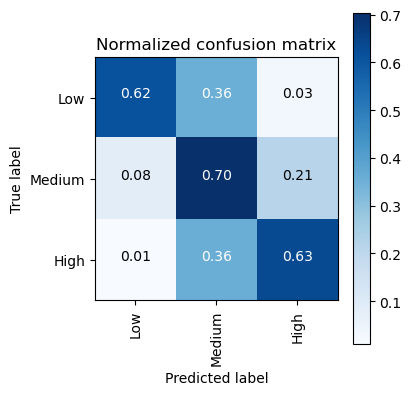

In [149]:
plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [151]:
# get classification report
print('-------------------------')
print('| Classifiction Report |')
print(classification_report(y_test, dp_pred))

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

           1       0.62      0.43      0.51      5025
           2       0.70      0.76      0.73     29652
           3       0.63      0.60      0.62     17444

    accuracy                           0.67     52121
   macro avg       0.65      0.60      0.62     52121
weighted avg       0.67      0.67      0.67     52121



### Tuning Parameter

In [123]:
from kerastuner.engine.hyperparameters import HyperParameters as hp
from tensorflow.keras.optimizers import SGD,Adam

In [124]:
def build_model(hp):
    model_tu = Sequential()

    model_tu.add(Dense(units=hp.Int('dense_bot', min_value=20, max_value=120, step=25), input_shape=(x_train.shape[1],), activation='relu'))

    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model_tu.add(Dense(units=hp.Int('dense_' + str(i), min_value=20, max_value=70, step=10), activation='relu'))
        model_tu.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2])))

    model_tu.add(Dense(3, activation="softmax"))

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate) 
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, nesterov=True, momentum=0.9)

    model_tu.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_m])

    return model_tu

In [125]:
tuner_ml = BayesianOptimization(
    build_model,
    seed=42,
    objective='accuracy',
    max_trials=30,
    directory='.',
    project_name='tuning-ml')

tuner_ml.search(x_train, y_train_ohc, epochs=30, batch_size=200)

Trial 30 Complete [00h 00m 45s]
accuracy: 0.6695942282676697

Best accuracy So Far: 0.6775709986686707
Total elapsed time: 00h 41m 59s


In [131]:
best_ml_hyperparameters = tuner_ml.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_ml_hyperparameters.values

Best Hyper-parameters


{'dense_bot': 95,
 'num_dense_layers': 2,
 'dense_0': 70,
 'dropout_0': 0.0,
 'optimizer': 'sgd',
 'learning_rate': 0.01,
 'dense_1': 45,
 'dropout_1': 0.1}

Since the optimal parameters yielded little improvement over the baseline, the fit was not continued

In [133]:
x = PrettyTable()
x.field_names=['model','Type','Micro average f1 score']
x.add_row(['1','KNN','0.65'])
x.add_row(['2','Logistic Regression','0.58'])
x.add_row(['3','SVM','0.60'])
x.add_row(['4','Random Forest','0.74'])
x.add_row(['5','XGBoost','0.73'])
x.add_row(['6','FFNN','0.67'])
print(x)

+-------+---------------------+------------------------+
| model |         Type        | Micro average f1 score |
+-------+---------------------+------------------------+
|   1   |         KNN         |          0.65          |
|   2   | Logistic Regression |          0.58          |
|   3   |         SVM         |          0.60          |
|   4   |    Random Forest    |          0.74          |
|   5   |       XGBoost       |          0.73          |
|   6   |         FFNN        |          0.67          |
+-------+---------------------+------------------------+


### 1 LSTM, 3 Dense layers

In [126]:
# Discard this as the result didn't improve significantly

In [133]:
x_train_=np.expand_dims(X_train1,axis = 2)
x_test_=np.expand_dims(X_test1,axis = 2)

In [132]:
y_train_=pd.get_dummies(y_train)
y_test_=pd.get_dummies(y_test)

In [134]:
timesteps=x_train_.shape[1]
feadim = 1

In [135]:
model2 = Sequential()
model2.add(LSTM(32, activation = "relu", input_shape = (timesteps, feadim)))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(3,activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32)                4352      
                                                                 
 dense_29 (Dense)            (None, 64)                2112      
                                                                 
 dense_30 (Dense)            (None, 3)                 195       
                                                                 
Total params: 6659 (26.01 KB)
Trainable params: 6659 (26.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
history=model2.fit(x_train_,y_train_,batch_size=64,epochs=30,verbose=1)

Epoch 1/30
3258/3258 [==============================] - 44s 13ms/step - loss: 0.8671 - accuracy: 0.5692 - f1_m: 0.5553
Epoch 2/30
3258/3258 [==============================] - 40s 12ms/step - loss: 0.8196 - accuracy: 0.5748 - f1_m: 0.5647
Epoch 3/30
3258/3258 [==============================] - 37s 11ms/step - loss: 0.7941 - accuracy: 0.6021 - f1_m: 0.5907
Epoch 4/30
3258/3258 [==============================] - 37s 11ms/step - loss: 0.7758 - accuracy: 0.6224 - f1_m: 0.6139
Epoch 5/30
3258/3258 [==============================] - 37s 11ms/step - loss: 0.7665 - accuracy: 0.6291 - f1_m: 0.6213
Epoch 6/30
3258/3258 [==============================] - 37s 11ms/step - loss: 0.7576 - accuracy: 0.6350 - f1_m: 0.6277
Epoch 7/30
3258/3258 [==============================] - 36s 11ms/step - loss: 0.7490 - accuracy: 0.6405 - f1_m: 0.6339
Epoch 8/30
3258/3258 [==============================] - 36s 11ms/step - loss: 1.3905 - accuracy: 0.6358 - f1_m: 0.6279
Epoch 9/30
 613/3258 [====>.....................

KeyboardInterrupt: 